<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/DataScience/210321_PCA_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 210321_PCA Revisited
한번 정도 공부를 했던 내용이나, 처음부터 다시 공부하고자 PCA를 다시 만나보았다.

## Covariance and Covariance Matrix 
먼저 PCA를 이해하기 위해서는 공분산과 공분산 행렬에 대해 이해해야 한다.


### Covariance
공분산의 목적은 두 변수간의 선형성을 측정하는 지표이다.
- $Cov(X, Y)>0$ : 두 변수는 양의 상관관계
- $Cov(X, Y)=0$ : 두 변수는 독립
- $Cov(X, Y)<0$ : 두 변수는 음의 상관관계

사실, 상관관계는 피어슨 상관관계 계수로 상관성의 정도를 파악할 수 있다.
Why? 공분산 자체로는 단위가 다를 경우, 값이 달리지는 현상이 발생한다.
이는 공분산의 공식을 통해 확인할 수 있다.

$$ Cov(x, y) = \frac{1}{n}\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})$$


### Covariance Matrix
공분산 행렬은 공분산의 모든 순서쌍을 행렬로 표현한 것이다.
이는 다음과 같은 형태를 가진다.
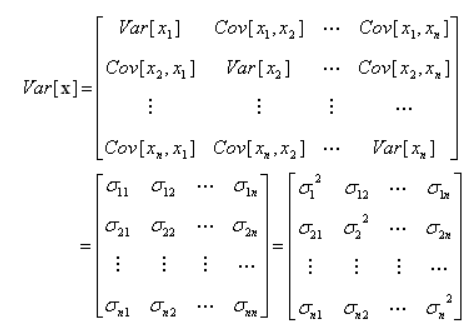


주목해야 할 점은, 이 행렬은 실수 대칭 행렬이라는 점이다. 따라서 eigenvalue를 항상 얻을 수 있음에 주목해야 할 것이다. (추후 SVD를 생각할 예정이다)

## PCA의 절차
1. 주어진 data set의 표준화 실시
 -> 표준화를 실시하는 이유는 공분산의 식을 고려하면 당연.
2.공분산 행렬을 만들고, 이를 eigenvalue decomposition 실시
3.eigenvalue들을 내림차순으로 정렬, 고유값이 가장 큰 벡터들 k개 선택
4.해당 벡터들로 projection matrix 생성
5.projection matrix를 활용하여 data set의 dimension 조절

각 과정별로 코드랑 함께 부가적인 배경 이론 설명을 덧붙이고자 한다.

### 데이터셋 준비 및 표준화 적용
이 단계에서는
 - 데이터 셋의 준비 및 훈련세트/테스트 세트 나누기
 - 표준화 적용
 의 단계를 거치고자 한다.

 책에서 사용한 wine dataset을 불러온다. 물론 직접 링크 말고 scikit-learn 내장 데이터를 사용할 예정이다.

In [3]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 데이터 불러오기
dataset = datasets.load_wine()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
print(df)

# 훈련세트 : 테스트세트 = 7 : 3
X, y =  df, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify = y,
                                                    random_state = 0)

# 표준화.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


     alcohol  malic_acid   ash  ...   hue  od280/od315_of_diluted_wines  proline
0      14.23        1.71  2.43  ...  1.04                          3.92   1065.0
1      13.20        1.78  2.14  ...  1.05                          3.40   1050.0
2      13.16        2.36  2.67  ...  1.03                          3.17   1185.0
3      14.37        1.95  2.50  ...  0.86                          3.45   1480.0
4      13.24        2.59  2.87  ...  1.04                          2.93    735.0
..       ...         ...   ...  ...   ...                           ...      ...
173    13.71        5.65  2.45  ...  0.64                          1.74    740.0
174    13.40        3.91  2.48  ...  0.70                          1.56    750.0
175    13.27        4.28  2.26  ...  0.59                          1.56    835.0
176    13.17        2.59  2.37  ...  0.60                          1.62    840.0
177    14.13        4.10  2.74  ...  0.61                          1.60    560.0

[178 rows x 13 columns]


### eigenvalue, eigenvector 얻기

공분산 행렬을 얻은 후 그 행렬의 eigenvalue, eigenvector들을 구하자.
numpy에 해당 기능이 잘 있다.

In [ ]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)
print(eigen_vecs)

총 13개의 eigen_val이 나오고, eigen_vecs로 행렬을 만들면 13 * 13의 정방행렬이 나오게 된다.

### eigen_vecs 선택하기

이를 위해서는 먼저 eigen-val, eigen-vec 끼리 짝지어 정렬해야 한다.

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vecs))]
eigen_pairs.sort(key = lambda k : k[0], reverse = True)

### 투영행렬의 계산
우리는 이 중 2개의 벡터만 선택할 것이다. 이미 고유값대로 정렬은 마무리했으므로 2개만 고르자.

In [6]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

### PCA의 최종 적용
scikit-learn의 PCA 패키지를 통해 최종 적용하자.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

pca.explained_variance_ratio_

array([0.3616524 , 0.23283881])